In [1]:
%pylab inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy import stats

warnings.filterwarnings('ignore')

def print_stationary_koef(frame):
    print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(frame)[1])

Populating the interactive namespace from numpy and matplotlib


In [2]:
df = pd.read_excel('data.xlsx', sheet_name='Timeseries', index_col="Date")
df.shape

(1369, 1)

In [3]:
df.columns = ['data']
df.head()

,data
Date,
2013-01-01,145
2013-01-02,1129
2013-01-03,1790
2013-01-04,1784
2013-01-05,1761


# First look at the data

    On the graphs below, we can see our data are very similar for all period. 
    So first we should check how we can predict it with a regression. 
    After that,  we will try to realize the ensemble of decision trees.
    And lastly, we will check the model SARIMA.

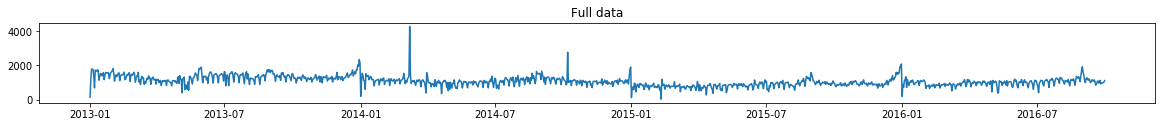

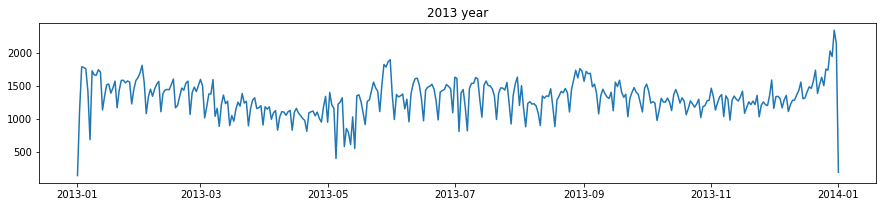

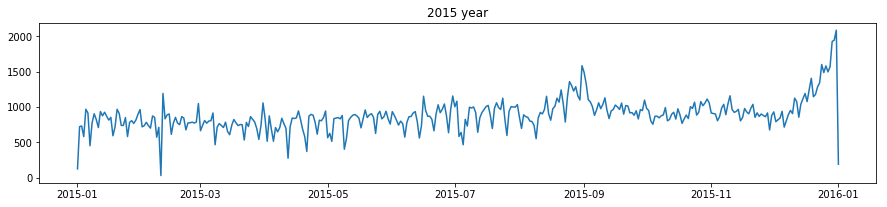

In [6]:
plt.figure(figsize=(20, 5))

ax = plt.subplot(311)
plt.plot(df.data)
plt.title("Full data")
plt.show()

ax = plt.subplot(312)
plt.plot(df.loc['2013-1-1':'2014-1-1'])
plt.title("2013 year")
plt.show()

ax = plt.subplot(313)
plt.plot(df.loc['2015-1-1':'2016-1-1'])
plt.title("2015 year")
plt.show()

#### Look at the data in more detail.

<Figure size 1080x720 with 0 Axes>

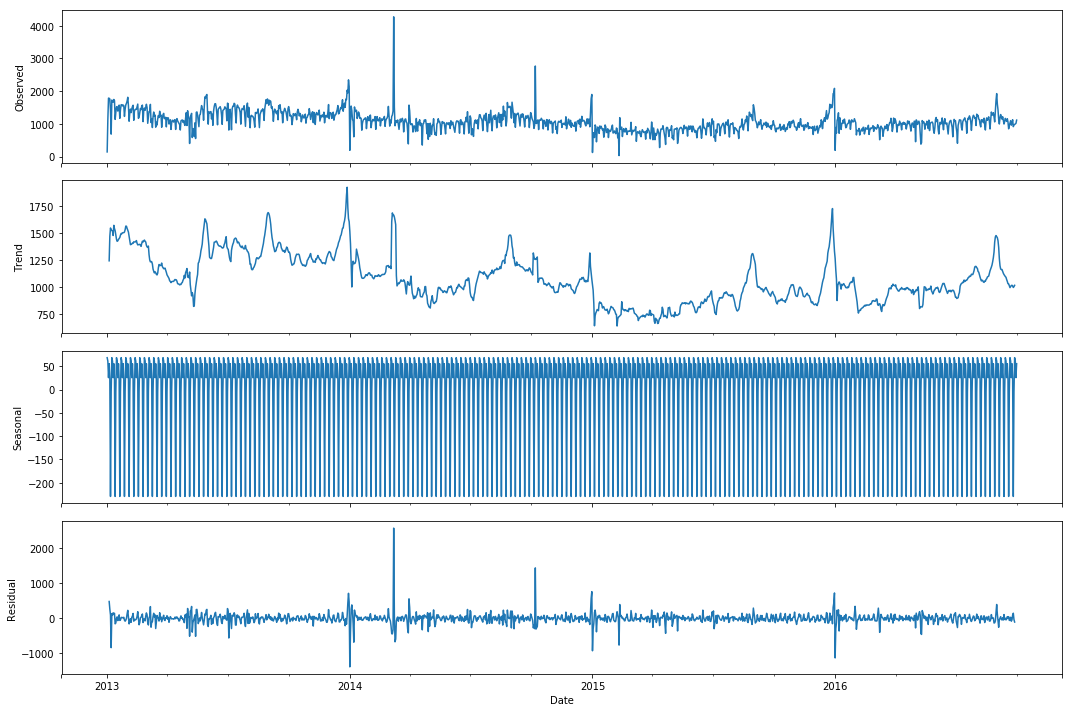

Критерий Дики-Фуллера: p=0.007005


In [5]:
plt.figure(figsize(15,10))
decomposition = sm.tsa.seasonal_decompose(df.data)

decomposition.plot()
plt.show()
print_stationary_koef(df.data)

     On the graph above we can see pronounced seasonality, so look at the seasonality in more details.

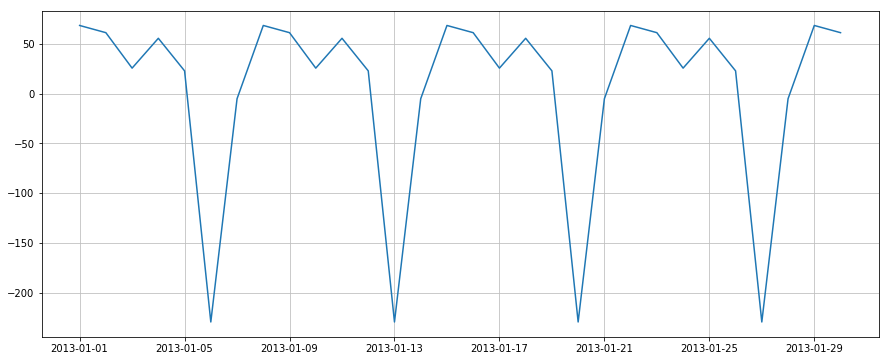

In [6]:
plt.figure(figsize=(15, 6))
plt.grid(True, linestyle='-', color= '0.75')
plt.plot(decomposition.seasonal[:30])

We can see the **seasonality period** equals **7 days**

# Data preprocessing
We will generate our data from 7 previous days (Our seasonality period).

In [7]:
def code_mean(data, cat_features, real_features):
    return dict(data.groupby(cat_features)[real_features].mean())

def prepareData(data, lag_start=1, lag_end=8, test_size=0.15):
    
    data = pd.DataFrame(data.copy())
    data.columns = ["y"]
    
    # after test_index will be test data
    test_index = int(len(data)*(1-test_size))
    
    # generate features
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
        
    # two more features
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    # 1 feater to 7, Great!
    data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))

    # now we have to drom this feature
    data.drop(["weekday"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)
    
    
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]
    
    return X_train, X_test, y_train, y_test

# Check how LinearRegression will work

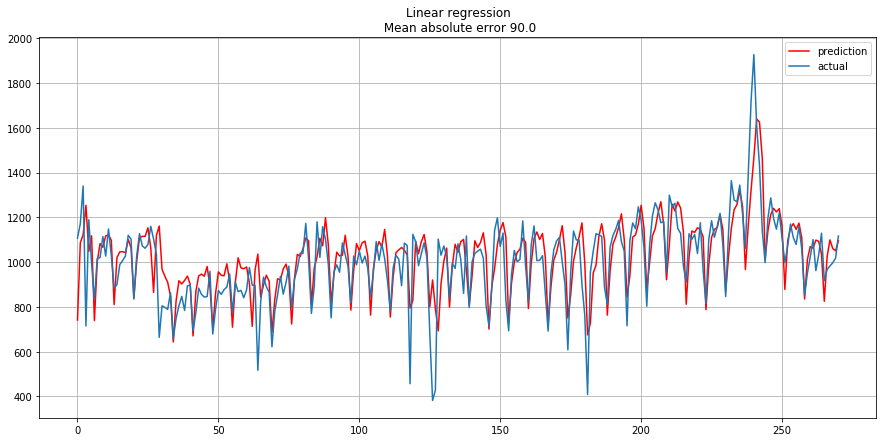

In [305]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler


X_train, X_test, y_train, y_test = prepareData(df, lag_start=1, lag_end=8, test_size=.2)


lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)
plt.figure(figsize=(15, 7))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {}".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);

Almost great! But it cold be better with another model. Maybe..

# XGBoost

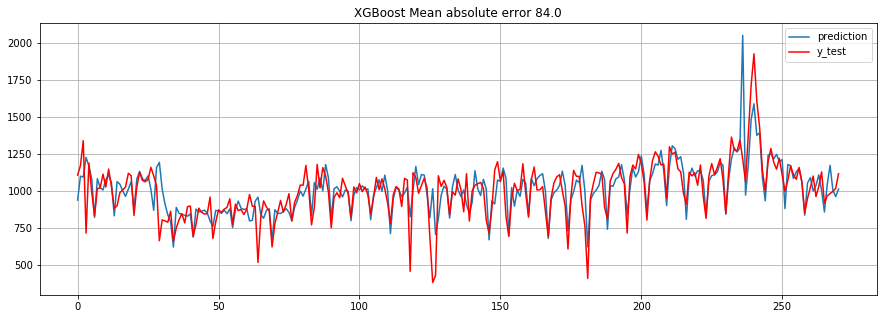

In [308]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(max_depth=3, n_estimators=100).fit(X_train, y_train)

prediction_test = xgb_model.predict(X_test)

plt.figure(figsize=(15, 5))
plt.plot(prediction_test, label="prediction")

plt.plot(list(y_test), label="y_test", c = 'r')

plt.title("XGBoost Mean absolute error {}".format(round(mean_absolute_error(prediction_test, y_test))))
plt.grid(True)
plt.legend()

Actually it's not bad. But we have to try another method.

# SARIMA

    We haven't got a dispersion on the graph but at the same time we have a very pronounced seasonality.
    Remove it with seasonal differentiation.

### 1 step - Seasonal Differentiation

Критерий Дики-Фуллера: p=0.000000


<Figure size 1080x720 with 0 Axes>

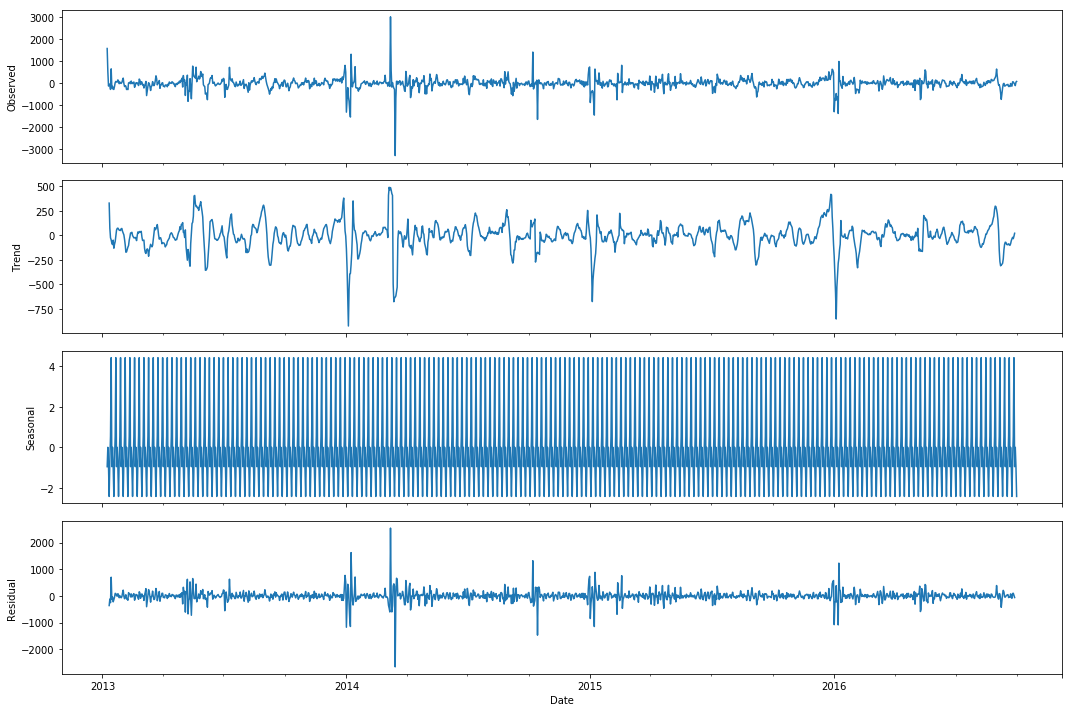

In [11]:
df['data_diff_s'] = df.data - df.data.shift(7)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(df.data_diff_s[7:]).plot()

print_stationary_koef(df.data_diff_s[7:])

### 2 step - Select the params

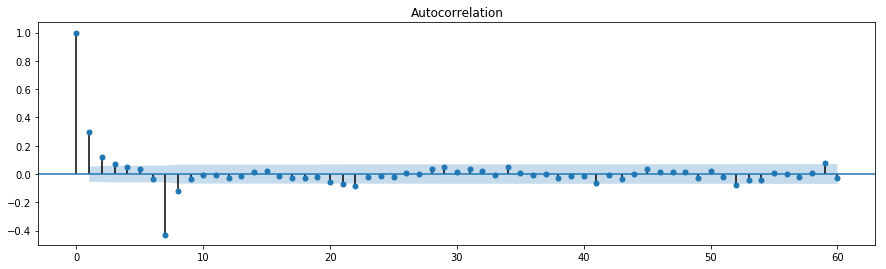

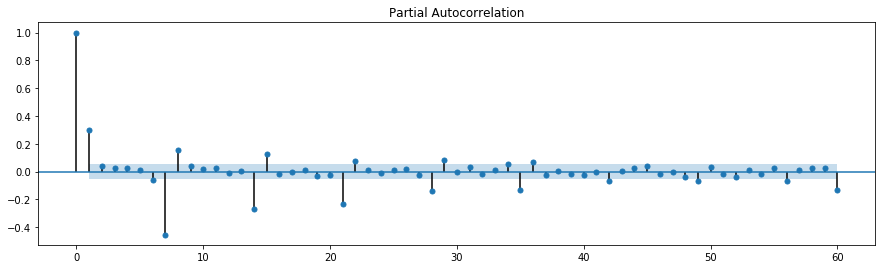

In [12]:
plt.figure(figsize(15,9))

ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(df.data_diff_s[7:].values.squeeze(), lags=60, ax=ax)
pylab.show()

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(df.data_diff_s[7:].values.squeeze(), lags=60, ax=ax)
pylab.show()

    q = 3
    Q = 2
    p = 1
    P = 6

In [37]:
from itertools import product

ps = range(0, 2)
d = 0
qs = range(0, 4)
Ps = range(0, 7)
D = 1
Qs = range(0, 3)

parameters = list(product(ps, qs, Ps, Qs))
len(parameters)

168

In [14]:
import sys

In [31]:
%%time
results = []
best_aic = float("inf")

for i, param in enumerate(parameters):
    sys.stdout.write('\r{}%'.format( i*100//len(parameters)))
    sys.stdout.flush()
    try:
        model=sm.tsa.statespace.SARIMAX(df.data, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 7)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = abs(model.aic)
    
    #save the best model
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    

87%wrong parameters: (1, 3, 0, 0)
88%wrong parameters: (1, 3, 0, 1)
88%wrong parameters: (1, 3, 0, 2)
89%wrong parameters: (1, 3, 1, 0)
89%wrong parameters: (1, 3, 1, 1)
90%wrong parameters: (1, 3, 1, 2)
91%wrong parameters: (1, 3, 2, 0)
91%wrong parameters: (1, 3, 2, 1)
92%wrong parameters: (1, 3, 2, 2)
92%wrong parameters: (1, 3, 3, 0)
93%wrong parameters: (1, 3, 3, 1)
94%wrong parameters: (1, 3, 3, 2)
94%wrong parameters: (1, 3, 4, 0)
95%wrong parameters: (1, 3, 4, 1)
95%wrong parameters: (1, 3, 4, 2)
96%wrong parameters: (1, 3, 5, 0)
97%wrong parameters: (1, 3, 5, 1)
97%wrong parameters: (1, 3, 5, 2)
98%wrong parameters: (1, 3, 6, 0)
98%wrong parameters: (1, 3, 6, 1)
99%wrong parameters: (1, 3, 6, 2)
Wall time: 29min 33s


In [32]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())


       parameters           aic
140  (1, 2, 4, 2)  18175.580883
145  (1, 2, 6, 1)  18178.751417
142  (1, 2, 5, 1)  18179.822430
139  (1, 2, 4, 1)  18181.310337
127  (1, 2, 0, 1)  18181.737998


In [36]:
sarima=sm.tsa.statespace.SARIMAX(df.data, order=(1, 0, 2), 
                                        seasonal_order=(4, 1, 2, 7)).fit(disp=-1)

Критерий Дики-Фуллера: p=0.000000


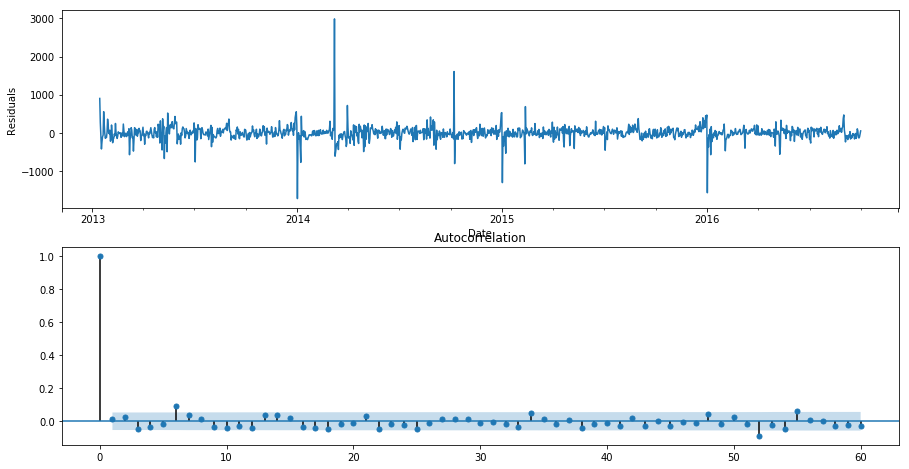

In [38]:
plt.figure(figsize(15,8))
plt.subplot(211)
sarima.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(sarima.resid[7:].values.squeeze(), lags=60, ax=ax)

print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(sarima.resid[1:])[1])

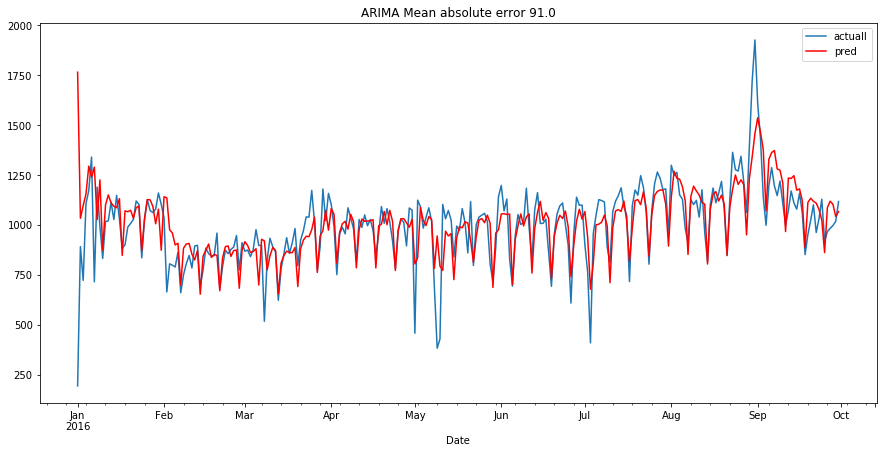

In [39]:
test_index = int(len(df)*(1-0.2))
df['model'] = sarima.fittedvalues
plt.figure(figsize(15,7))

df.data[test_index:].plot(label = 'actuall')
df.model[test_index:].plot(color='r', label = 'pred')

plt.title("ARIMA Mean absolute error {}".format(round(mean_absolute_error(df.data[test_index:], df.model[test_index:]))))
plt.legend()
pylab.show()

SARIMA model is worse than another ones.

# Prediction the next 3 months

In [312]:
def get_X(data ,lag_start=0, lag_end=3):
    
    data = pd.DataFrame(data[-lag_end:].copy())
    data.columns = ["y"]
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i+1)] = data.y.shift(i)
        
    # two more features
    data["weekday"] = data.index.weekday
    data['is_weekend'] = data.weekday.isin([5,6])*1
    
    data['weekday_average'] = list(map(code_mean(data, 'weekday', "y").get, data.weekday))

    # now we have to drom this feature
    data.drop(["weekday"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)
    
    
    x = data.drop(["y"], axis=1)
    
    return x


def get_prediction(model, data, num_days):
    data_gen = pd.DataFrame(df.data.copy())
    for _ in range(num_days):
        
        x = get_X(data_gen)
        y = model.predict(x)
        new_data = datetime.datetime.strptime("{}".format(data_gen.index[-1].date()), "%Y-%m-%d") + relativedelta(days=1)
        data_gen.loc[new_data] = y
    return data_gen

In [313]:
df2 = df[['data']]
date_list = [datetime.datetime.strptime("2016-09-30", "%Y-%m-%d") + relativedelta(days=x) for x in range(0,100)]
future = pd.DataFrame(index=date_list, columns= df2.columns)
df2 = pd.concat([df2, future])

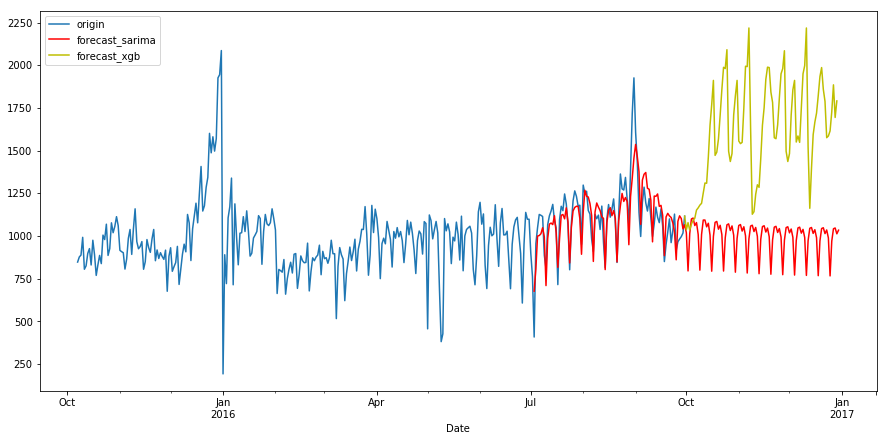

In [315]:
df2['forecast_sarima'] = sarima.predict(df.shape[0]-90, end = df.shape[0]+90)
df2['forecast_xgb'] = get_prediction(xgb_model, df, 90)
plt.figure(figsize(15,7))
df.data[-360:].plot(label="origin")
df2.forecast_sarima.plot(color='r')
df2.forecast_xgb[-100:].plot(color='y')
plt.legend()
pylab.show()



In [298]:
#linear doesn't work
b = get_prediction(lr, df, 90)

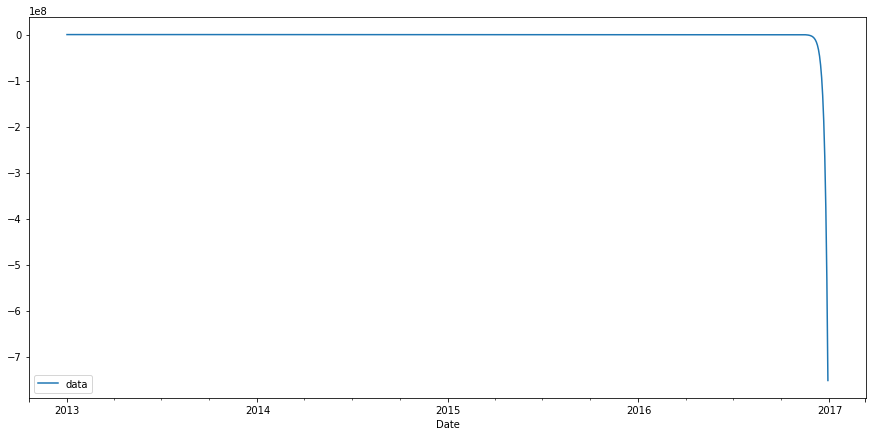

In [290]:
b.plot()